# DOG DISEASE DETECTION

In [ ]:
!pip install tensorflow==2.13.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [3]:
import os
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Exploration

In [4]:
path_img='/kaggle/input/skin-disease-dogs/Skin_Disease_Augment'
img_directory=os.listdir(path_img)
print("Class Skin Diseases:",img_directory)

Class Skin Diseases: ['earinfection', 'dermatitis', 'skintumors', 'fleas', 'dandruff', 'ringworm']


# Splitting Data

In [5]:
folder_path = '/kaggle/working/'
for i in ["train","validation"]:
    work_path_parent = Path(folder_path+i)
    work_path_parent.mkdir(exist_ok=True)
    for j in img_directory:
        work_path = Path(folder_path+i+"/"+j)
        work_path.mkdir(exist_ok=True)

In [6]:
def split_data(split_size,path_img,img_directory,train_directory,validation_directory):
    files=[]
    for file_dir in img_directory:
        name_image=[]
        for filename in os.listdir(path_img+"/"+file_dir):
            file=path_img+"/"+file_dir+"/"+filename
            if os.path.getsize(file) > 0:
                name_image.append(filename)
            else:
                print(filename + " is zero length, so ignoring.")
        files.append(name_image)
    for index,path_image in enumerate(files):
        train_len=int(len(path_image)*split_size)
        shuffle=random.sample(path_image,len(path_image))
        train_data=path_image[:train_len]
        validation_data=path_image[train_len:]
        for filename in train_data:
            file=path_img+"/"+img_directory[index]+"/"+filename
            destination=train_directory+img_directory[index]+"/"+filename
            copyfile(file,destination)
        for filename in validation_data:
            file=path_img+"/"+img_directory[index]+"/"+filename
            destination=validation_directory+img_directory[index]+"/"+filename
            copyfile(file,destination)

train_directory="/kaggle/working/train/"
validation_directory="/kaggle/working/validation/"
split_size=.8
split_data(split_size,path_img,img_directory,train_directory,validation_directory)

# Dataset

In [7]:
TRAINING_DIR = train_directory
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))
VALIDATION_DIR = validation_directory
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

Found 3599 images belonging to 6 classes.
Found 901 images belonging to 6 classes.


Found 3599 files belonging to 6 classes.
['dandruff', 'dermatitis', 'earinfection', 'fleas', 'ringworm', 'skintumors']


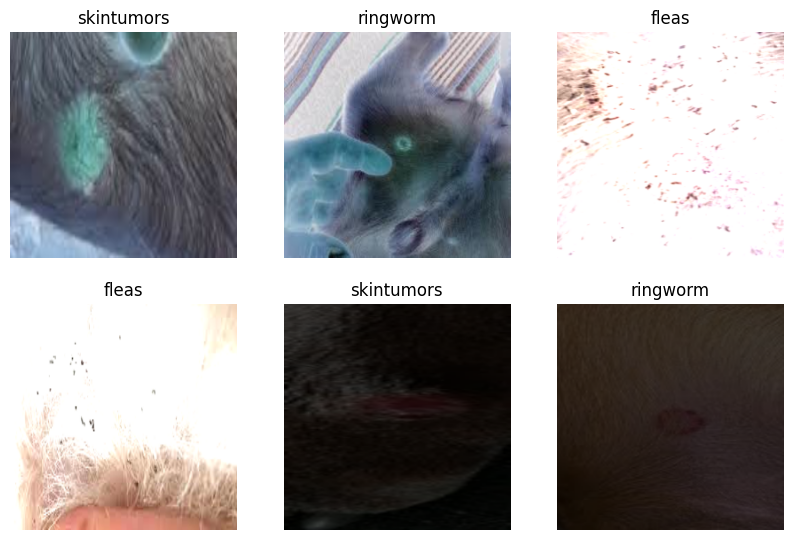

In [8]:
data = tf.keras.preprocessing.image_dataset_from_directory(train_directory)

class_names = data.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Load InceptionV3 Pretrained Model

In [9]:
pre_trained_model =  tf.keras.applications.InceptionV3(input_shape=(150,150,3),
                                                       include_top=False,
                                                       weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


# Freeze Layer

In [10]:
for layer in pre_trained_model.layers:
    layer.trainable = False

# Get Last Layer

In [11]:
last_layer =  pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Add Dense Layer & Compile Model

In [12]:
x = layers.LayerNormalization()(last_output)
x = layers.Flatten()(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

# Train Model

In [13]:
model.fit(train_generator,
                  epochs=100,
                  validation_data=validation_generator)

Epoch 1/100
113/113 [==============================] - 73s 609ms/step - loss: 1.1318 - accuracy: 0.5841 - precision: 0.7045 - recall: 0.4432 - val_loss: 0.6450 - val_accuracy: 0.7902 - val_precision: 0.8796 - val_recall: 0.6326
Epoch 2/100
113/113 [==============================] - 67s 595ms/step - loss: 0.6718 - accuracy: 0.7438 - precision: 0.8068 - recall: 0.6766 - val_loss: 0.4187 - val_accuracy: 0.8380 - val_precision: 0.8640 - val_recall: 0.7969
Epoch 3/100
113/113 [==============================] - 78s 687ms/step - loss: 0.5063 - accuracy: 0.8127 - precision: 0.8574 - recall: 0.7733 - val_loss: 0.3362 - val_accuracy: 0.8724 - val_precision: 0.9054 - val_recall: 0.8502
Epoch 4/100
113/113 [==============================] - 68s 597ms/step - loss: 0.4244 - accuracy: 0.8447 - precision: 0.8744 - recall: 0.8163 - val_loss: 0.3268 - val_accuracy: 0.8724 - val_precision: 0.8972 - val_recall: 0.8524
Epoch 5/100
113/113 [==============================] - 79s 703ms/step - loss: 0.3729 - a

# Evaluation Model

In [14]:
evaluate_model=model.evaluate(validation_generator)

29/29 [==============================] - 11s 374ms/step - loss: 0.1172 - accuracy: 0.9667 - precision: 0.9666 - recall: 0.9634


# Test Model

In [15]:
class_map = train_generator.class_indices
classes_disease = []
for key in class_map.keys():
    classes_disease.append(key)
print(classes_disease)

['dandruff', 'dermatitis', 'earinfection', 'fleas', 'ringworm', 'skintumors']


1/1 [==============================] - 1s 961ms/step


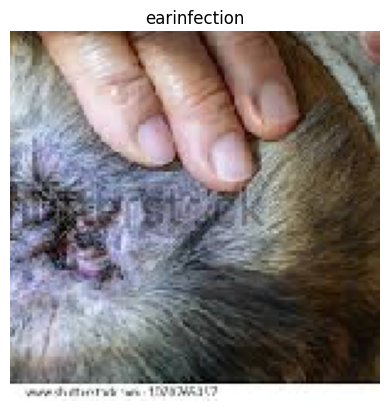

1/1 [==============================] - 0s 43ms/step


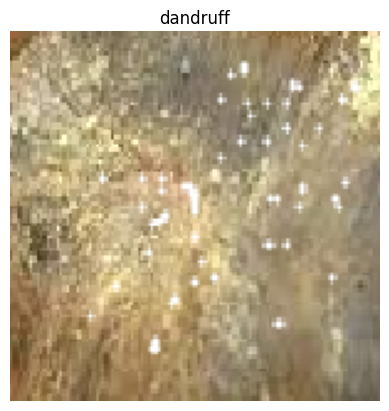

1/1 [==============================] - 0s 39ms/step


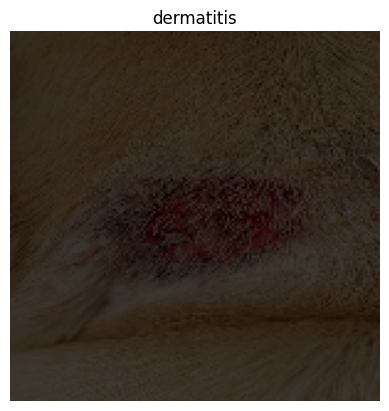

1/1 [==============================] - 0s 38ms/step


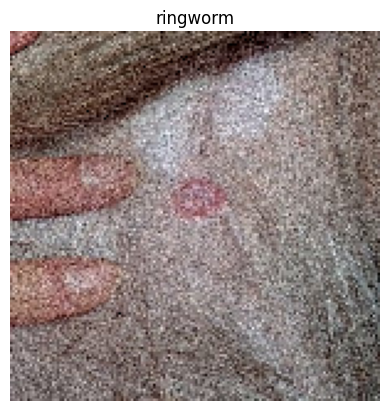

1/1 [==============================] - 0s 38ms/step


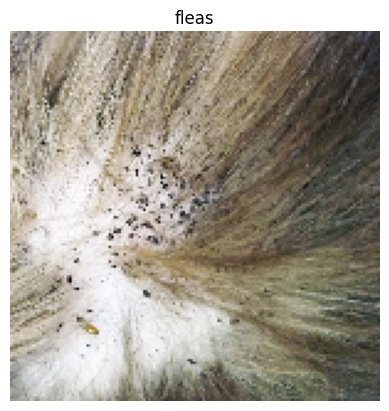

1/1 [==============================] - 0s 39ms/step


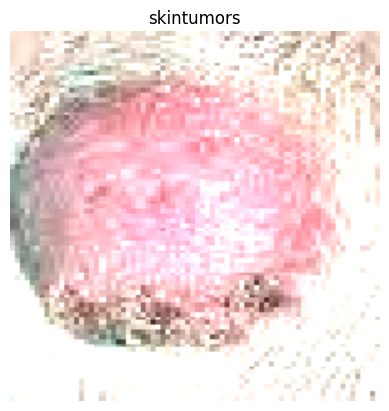

In [16]:
for i in os.listdir('/kaggle/working/validation'):
    for j in os.listdir('/kaggle/working/validation/'+i):
        path='/kaggle/working/validation/'+i+'/'+j
        img = tf.keras.utils.load_img(path, target_size=(150, 150))
        x = tf.keras.utils.img_to_array(img)
        x /= 255
        x = np.expand_dims(x, axis=0)
        image_tensor = np.vstack([x])
        classes = model.predict(image_tensor)
        predicted_class=classes_disease[np.argmax(classes[0])]
        plt.figure()
        plt.imshow(img)
        plt.title(predicted_class)
        plt.axis('off')
        plt.show()
        break

# Save Model and Convert Model To TFJS

In [17]:
model.save("model_saved.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# tf.keras.models.save_model(
#     model, "/kaggle/working/")

In [19]:
saved_model_path = Path('/kaggle/working/'+"saved_model")
saved_model_path.mkdir(exist_ok=True)
tf.saved_model.save(model, "/kaggle/working/saved_model")

In [ ]:
!pip install tensorflowjs

In [21]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='skin_disease_detection' \
    --saved_model_tags=serve \
    /kaggle/working/saved_model \
    /kaggle/working/tfjs

2024-06-13 15:46:17.113982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 15:46:17.114036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 15:46:17.115499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
